In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV

In [11]:
data = pd.read_csv('bankruptcy.csv')
data.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [12]:
data.shape

(6819, 96)

In [13]:
neg, pos = np.bincount(data['Bankrupt?'])
total = neg + pos
print('Total: {}\nDefault: {} ({:.2f}% of the Total)\n'.format(total, pos, 100 * pos / total))

Total: 6819
Default: 220 (3.23% of the Total)



In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [15]:
# Check the columns with integers
data.iloc[:,[85,94]].describe()

,Liability-Assets Flag,Net Income Flag
count,6819.000000,6819.0
mean,0.001173,1.0
std,0.034234,0.0
min,0.000000,1.0
25%,0.000000,1.0
50%,0.000000,1.0
75%,0.000000,1.0
max,1.000000,1.0


In [16]:
# Drop unhelpful columns 
data.drop(' Net Income Flag',axis=1, inplace=True)
data.drop(' Liability-Assets Flag',axis=1, inplace=True)

## Visualization

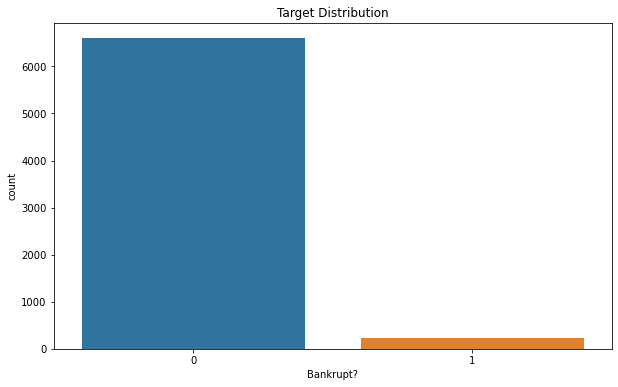

In [17]:
sns.countplot(data['Bankrupt?'])
plt.title('Target Distribution')
plt.show()

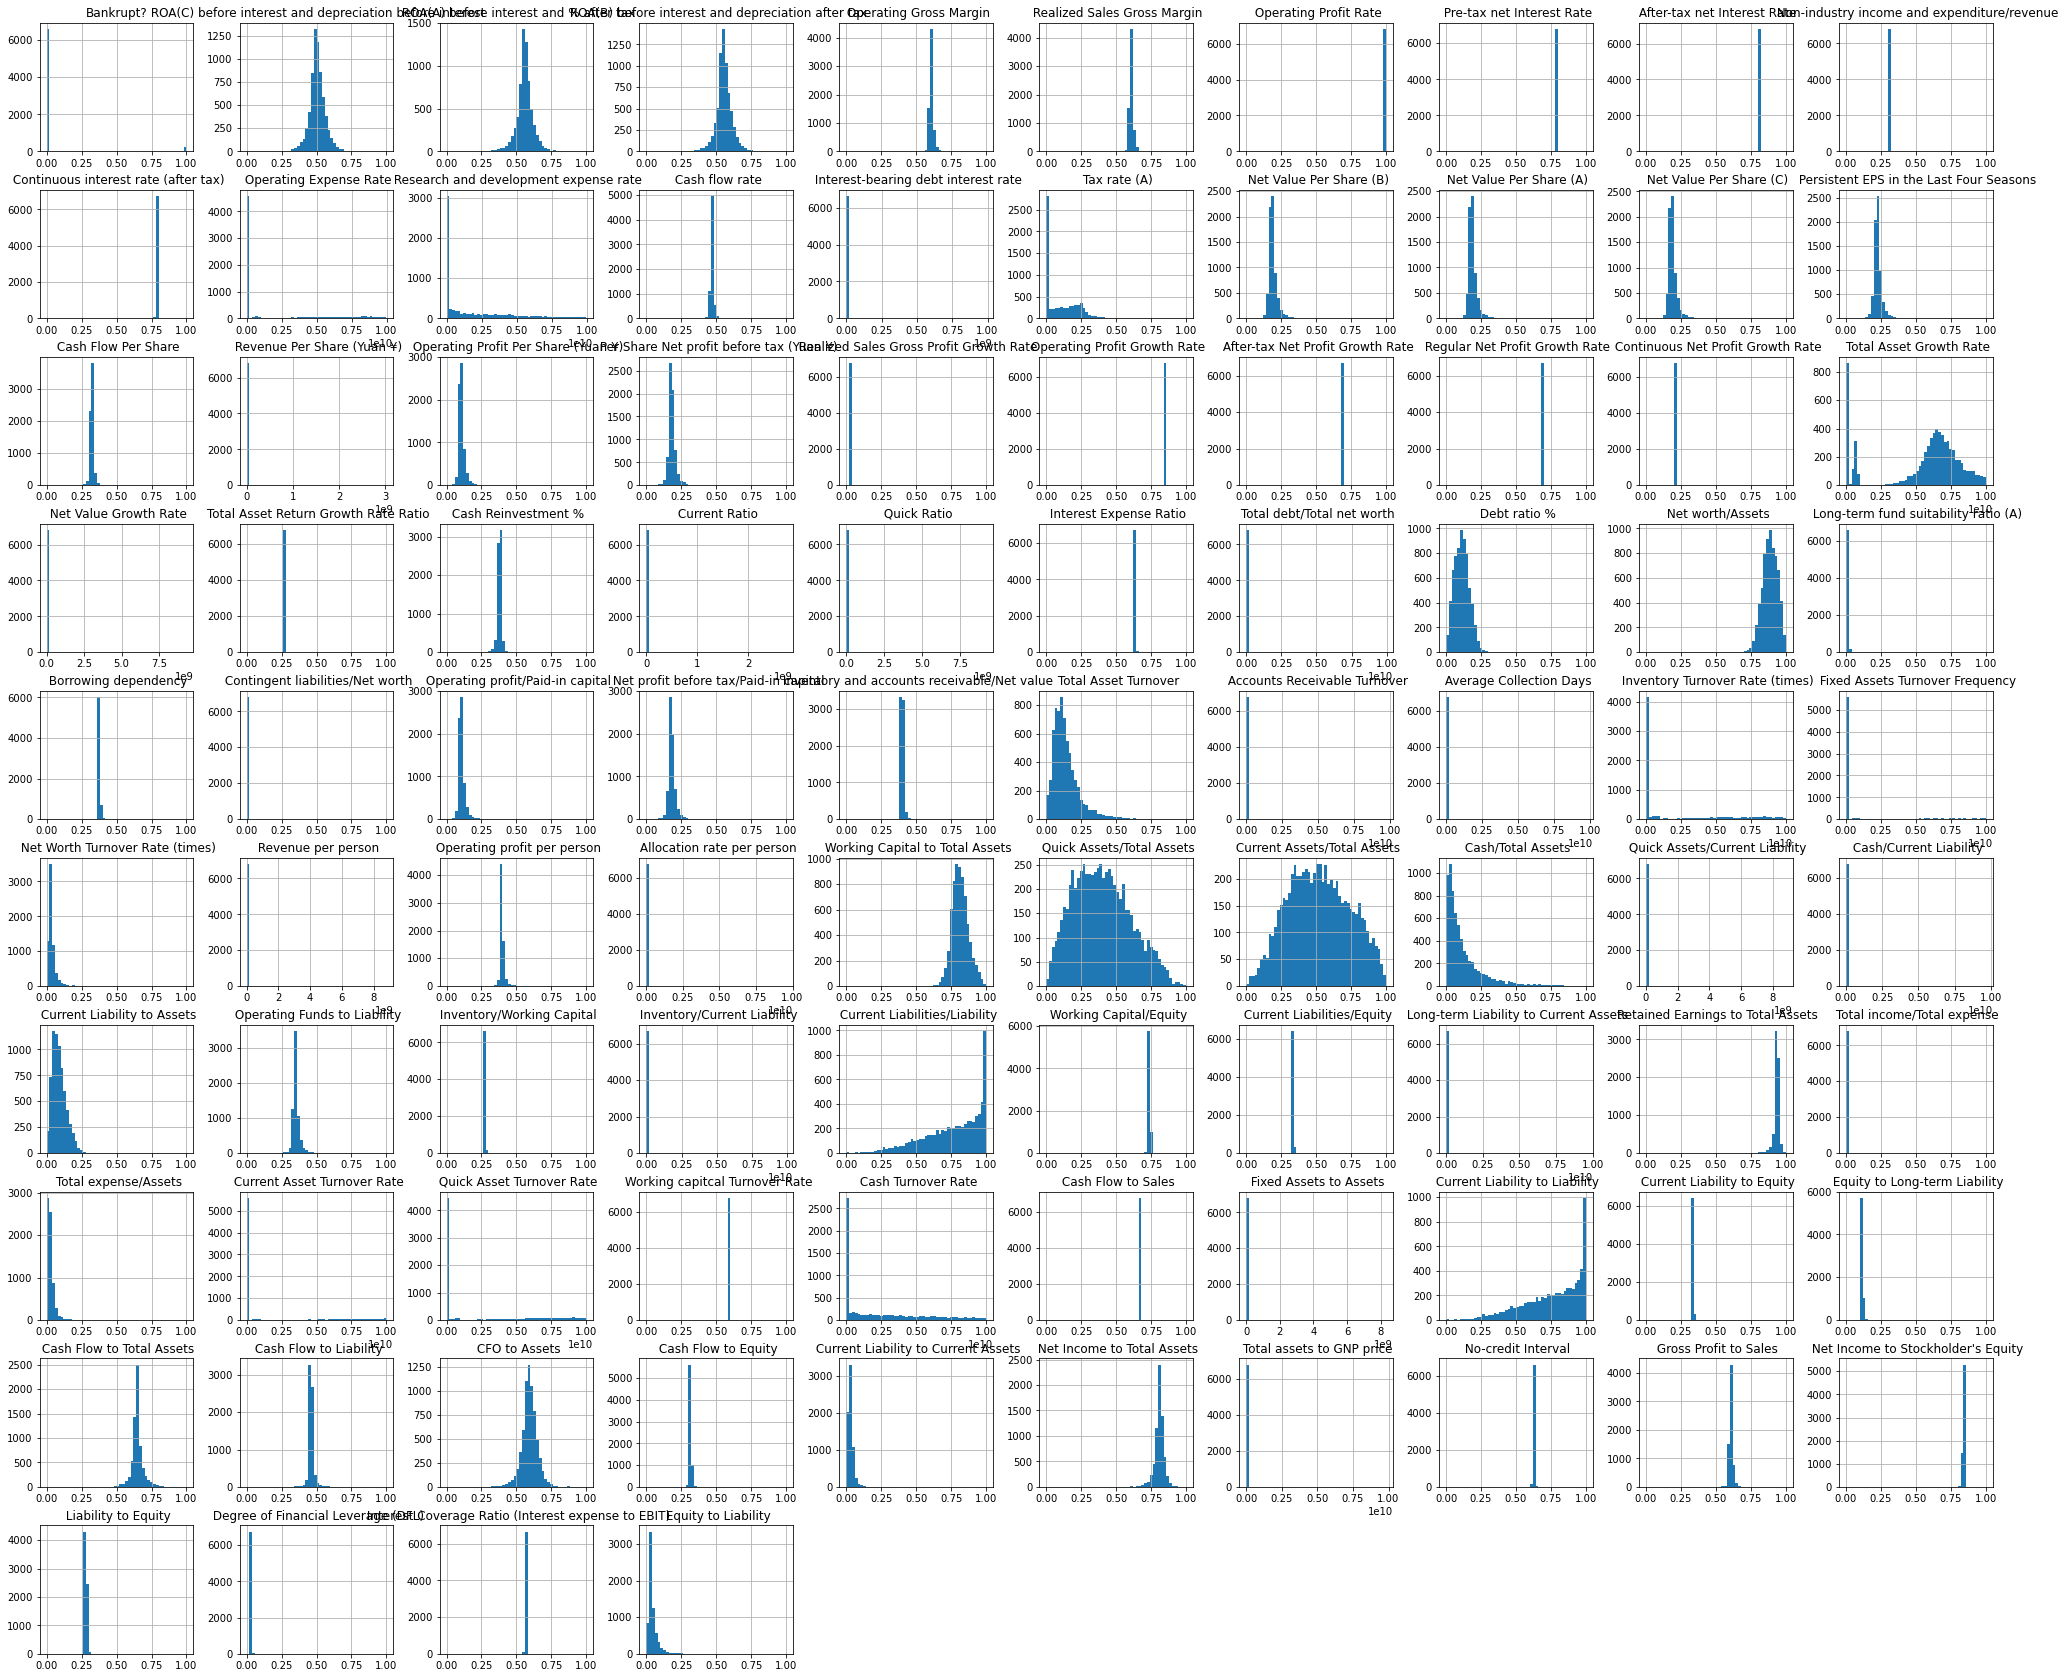

In [18]:
data.hist(figsize = (35,30), bins = 50)
plt.show()

In [19]:
def removeOutliers(feature,feature_name,dataset):

    q1, q3 = np.percentile(feature, 25), np.percentile(feature, 75)
    box = q3 - q1    
    fence = box * 1.5
    lower_fence = q1 - box
    upper_fence = q3 + box
    
    outliers = [x for x in feature if x < lower_fence or x > upper_fence]

    dataset = dataset.drop(dataset[(dataset[feature_name] > upper_fence)\
                                   | (dataset[feature_name] < lower_fence)].index)
    
    return dataset

for col in data:
    new_data = removeOutliers(data[col],str(col),data)
print("Removed {} outliers".format(len(data) - len(new_data)))
print("Removed {} Positives".format(data.iloc[:,0].sum()-new_data.iloc[:,0].sum()))

Removed 786 outliers
Removed 2 Positives


In [20]:
new_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.118250,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.025346,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.067250,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.047725,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


In [21]:
# Transform skewed datas
def feature_transormation(data):
    cnt = 0
    for col in data:
        skew = data[col].skew()
        if abs(skew) > 3:
            data[col] = np.log1p(data[col])
            print("{} has been transformed".format(col))
            cnt += 1
        else:
            continue;
    print("{} features has been transformed".format(cnt))
    return data
X = feature_transormation(new_data.iloc[:,1:]) 
y = new_data.iloc[:,0]

 Operating Gross Margin has been transformed
 Realized Sales Gross Margin has been transformed
 Operating Profit Rate has been transformed
 Pre-tax net Interest Rate has been transformed
 After-tax net Interest Rate has been transformed
 Non-industry income and expenditure/revenue has been transformed
 Continuous interest rate (after tax) has been transformed
 Interest-bearing debt interest rate has been transformed
 Net Value Per Share (B) has been transformed
 Net Value Per Share (A) has been transformed
 Net Value Per Share (C) has been transformed
 Persistent EPS in the Last Four Seasons has been transformed
 Cash Flow Per Share has been transformed
 Revenue Per Share (Yuan ¥) has been transformed
 Operating Profit Per Share (Yuan ¥) has been transformed
 Per Share Net profit before tax (Yuan ¥) has been transformed
 Realized Sales Gross Profit Growth Rate has been transformed
 Operating Profit Growth Rate has been transformed
 After-tax Net Profit Growth Rate has been transformed


In [22]:
X.shape

(6033, 93)

In [23]:
y.shape

(6033,)

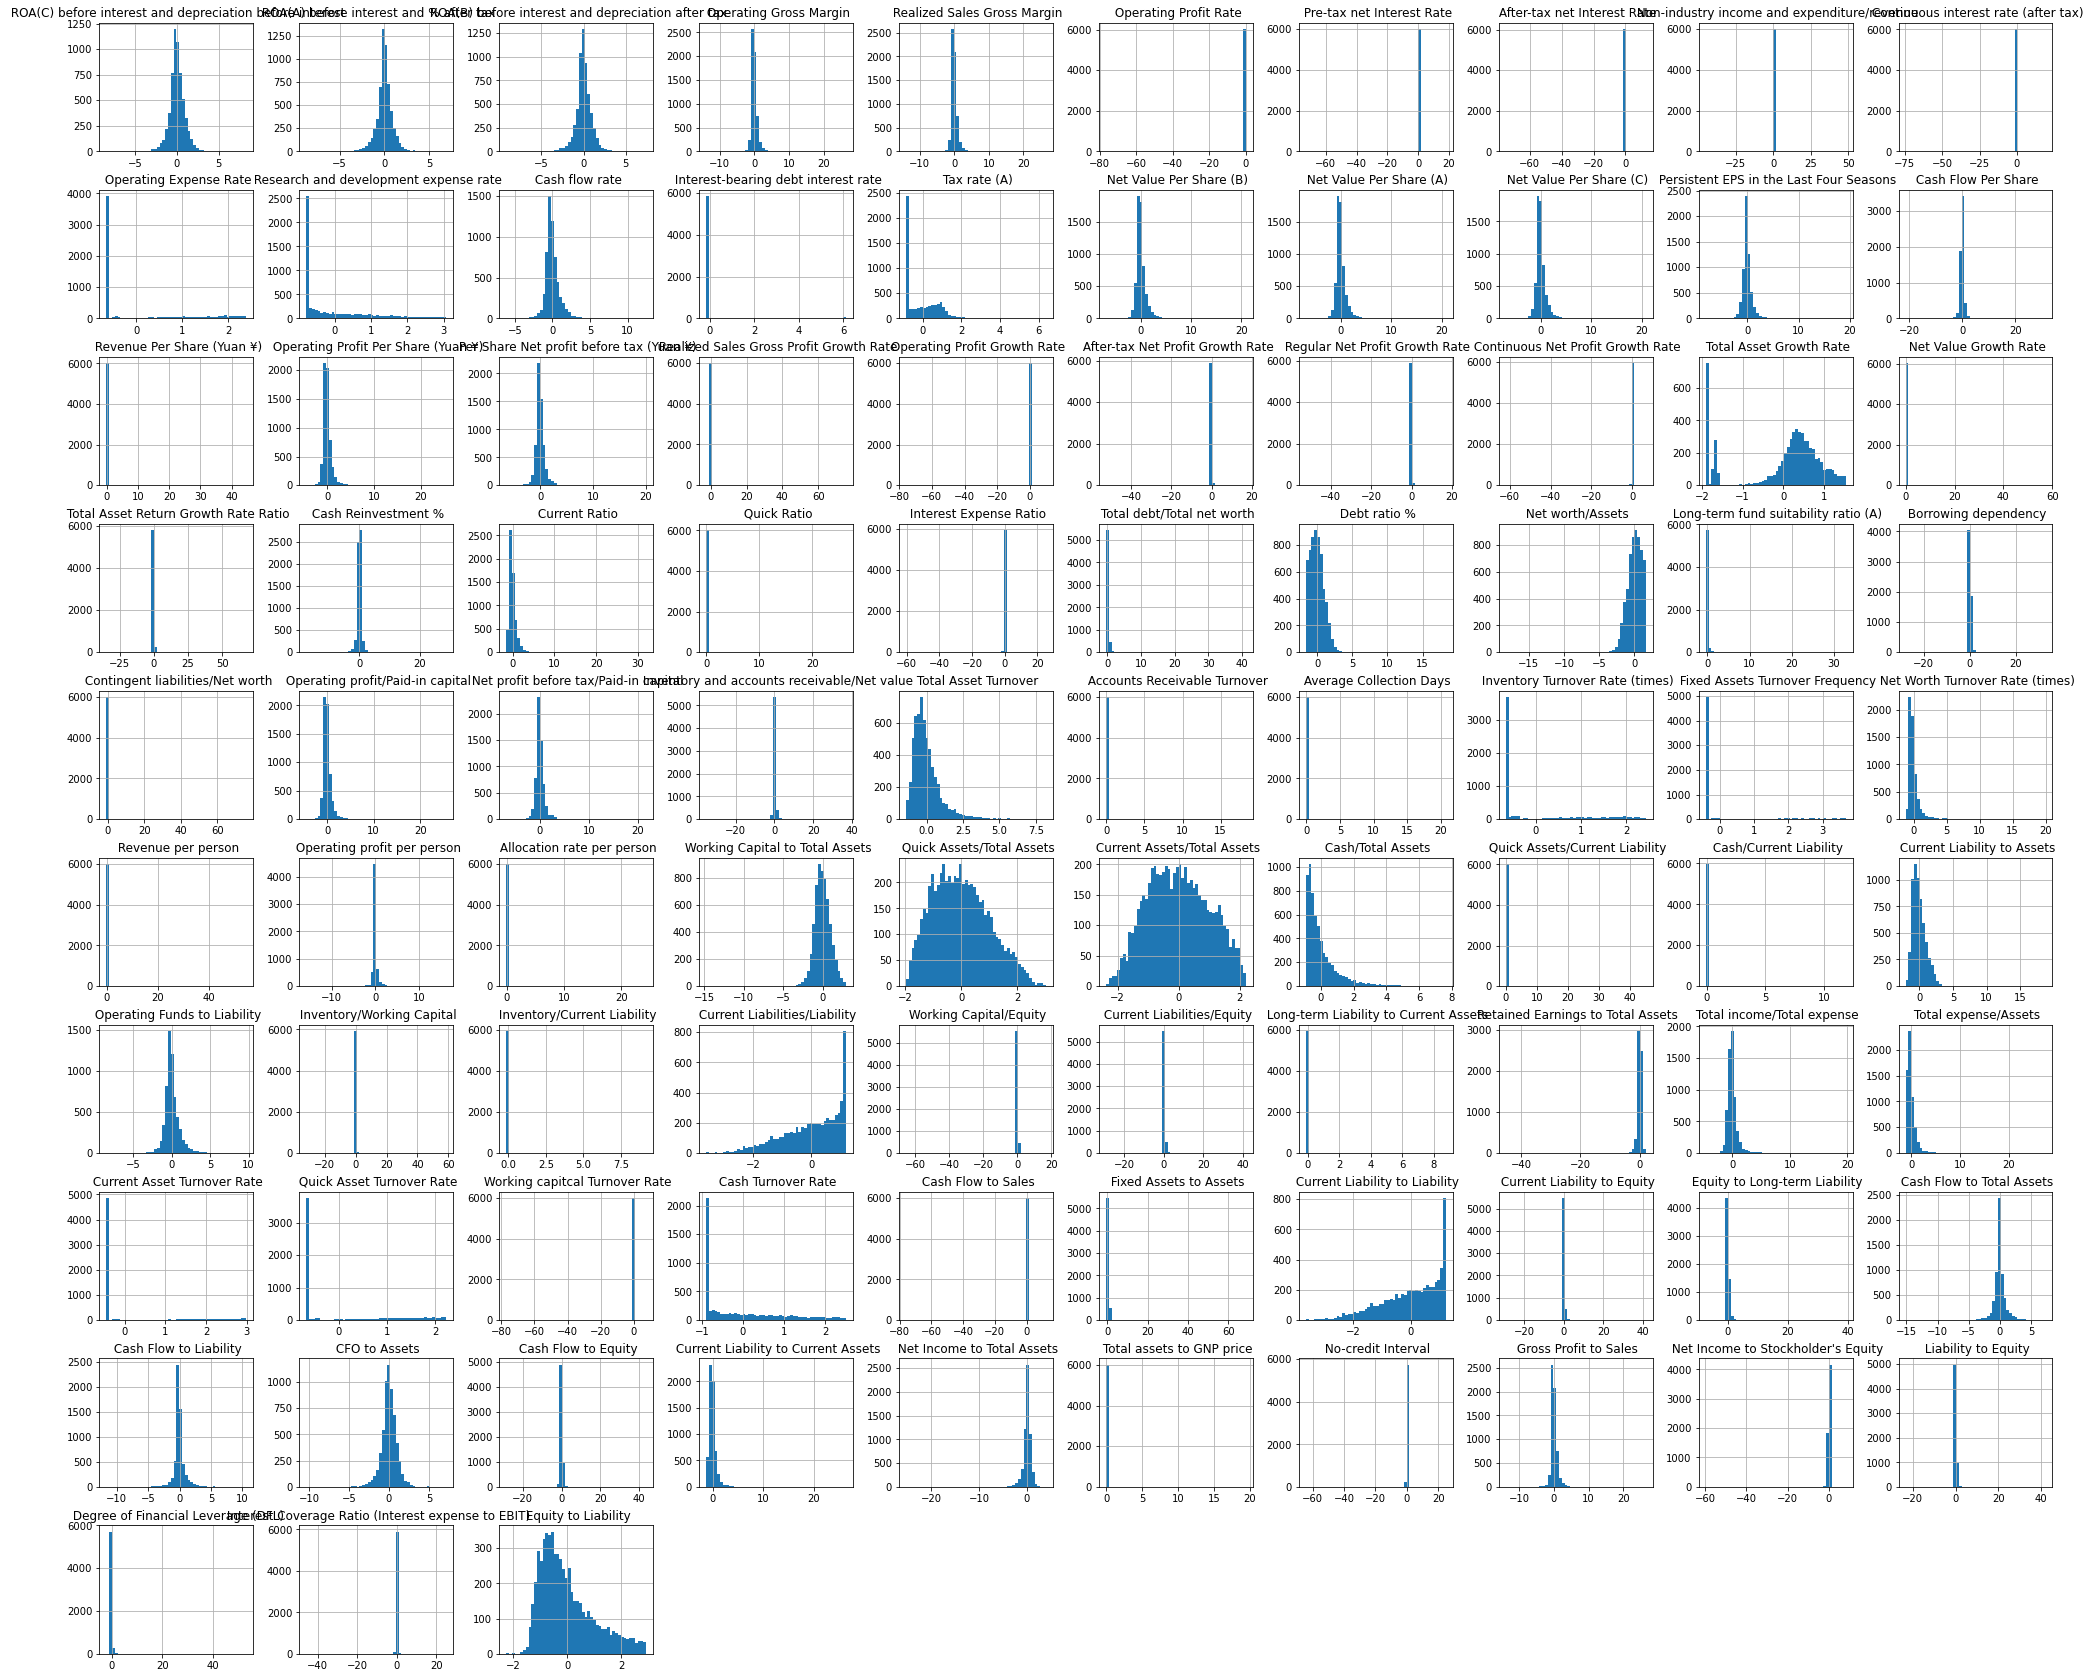

In [24]:
X_scaled = X.apply(lambda x: (x - x.mean()) / (x.std()))
X_scaled.fillna(0, inplace=True)
X_scaled.hist(figsize = (35,30), bins = 50)
plt.show()

In [25]:
# Temp sets for oversampling 
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled,y,
                                                   test_size = 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,
                                                   test_size = 0.5, random_state=42)

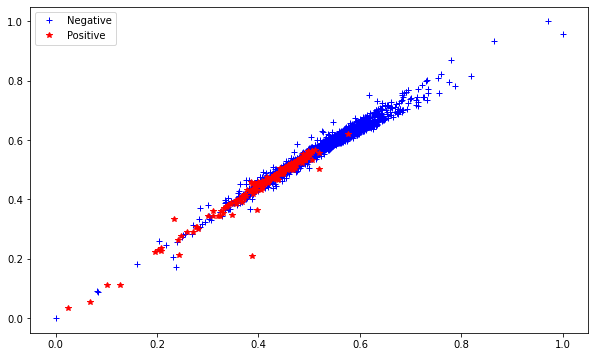

In [26]:
plt.plot( X[y == 0].iloc[:,0], X[y == 0].iloc[:,2], 'b+', label = 'Negative')
plt.plot( X[y == 1].iloc[:,0], X[y == 1].iloc[:,2], 'r*', label = 'Positive')
plt.legend()
plt.show()

In [27]:
from imblearn.over_sampling import SMOTE
oversampleS = SMOTE(sampling_strategy='minority', random_state = 42)
OverXS, OveryS = oversampleS.fit_resample(X_train, y_train) #train set only
Xconc, yconc = oversampleS.fit_resample(pd.concat([X_train,X_val]), pd.concat([y_train,y_val])) #train set only

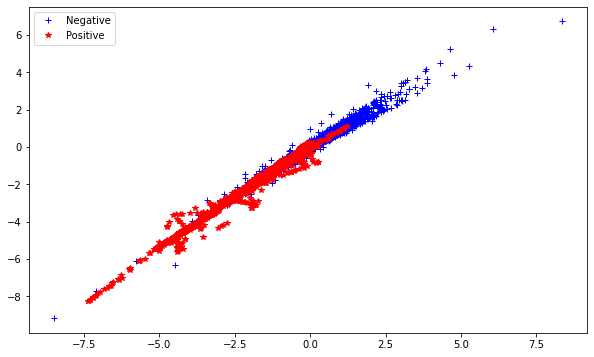

In [28]:
plt.plot( OverXS[OveryS == 0].iloc[:,0], OverXS[OveryS == 0].iloc[:,2], 'b+', label = 'Negative')
plt.plot( OverXS[OveryS == 1].iloc[:,0], OverXS[OveryS == 1].iloc[:,2], 'r*', label = 'Positive')
plt.legend()
plt.show()

# Models

In [31]:
res = dict() # to save results by model

## Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
costs = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]
LR = dict()
best_LR = 0
for cost in costs:
    lf_clf = LogisticRegression(penalty = 'l2', C = cost) # 
    lf_clf.fit(X_train, y_train)
    y_pred0 = lf_clf.predict(X_test)
    score = f1_score(y_test, y_pred0)
    LR[cost] = f1_score(y_test, y_pred0)
    if score > best_LR:
        best_LR = score
res['Logistic Regression'] = best_LR
print(f'F1 Score of Logistic Regression is {best_LR:.5f}')

F1 Score of Logistic Regression is 0.34483


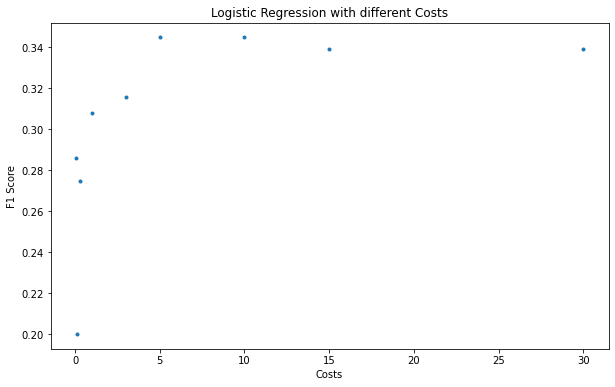

In [62]:
LR_sr = pd.Series(LR)
LR_sr.plot(style = '.',title = "Logistic Regression with different Costs")
plt.xlabel("Costs")
plt.ylabel("F1 Score")
plt.show()

In [63]:
# With oversampled Dataset => F1 Score drops
LRO = dict()
best_LRO = 0
for cost in costs:
    lf_clf = LogisticRegression(penalty = 'l2', C = cost)
    lf_clf.fit(Xconc, yconc) 
    y_pred1 = lf_clf.predict(X_test)
    score = f1_score(y_test, y_pred1)
    LRO[cost] = f1_score(y_test, y_pred1)
    if score > best_LRO:
        best_LRO = score
res['Logistic Regression OverSample'] = best_LRO
print(f'F1 Score of Logistic Regression with SMOTE is {best_LRO:.5f}')
print(f"By SMOTE f1 score Improved {best_LRO - best_LR:.6f}")

F1 Score of Logistic Regression with SMOTE is 0.28571
By SMOTE f1 score Improved -0.059113


## Random Forest

In [66]:
# Random Initial Guess
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1)
rf_clf.fit(Xconc, yconc)
y_pred2 = rf_clf.predict(X_test)
f1_score(y_test, y_pred2)

0.5714285714285715

In [67]:
res['RF random guess'] = f1_score(y_test, y_pred2)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1170
           1       0.51      0.65      0.57        37

    accuracy                           0.97      1207
   macro avg       0.75      0.81      0.78      1207
weighted avg       0.97      0.97      0.97      1207



### Randomized Search

In [70]:
from sklearn.model_selection import RandomizedSearchCV
rfparam_grid = {
    'n_estimators':[100, 200, 300],
    "max_depth": [None],
    'bootstrap': [True, False],
    'min_samples_split' : [6,8,10]
}

In [71]:
gridrfconc = RandomizedSearchCV(RandomForestClassifier(random_state = 1),
                                param_distributions=rfparam_grid, cv=5,
                      verbose=1, scoring='f1', refit=True
                      )
gridrfconc_result = gridrfconc.fit(Xconc, yconc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [73]:
rfconc_df = pd.DataFrame(gridrfconc_result.cv_results_)

rfconc_final = gridrfconc_result.best_estimator_

rfconc_y_pred = rfconc_final.predict(X_test)
rfconc_f1 = f1_score(y_test, rfconc_y_pred)

res['RF with RSCV'] = rfconc_f1
print("F1 score with rf Randomsearch : {:.6f}".format(rfconc_f1))

F1 score with rf Randomsearch : 0.567568


In [74]:
print(classification_report(y_test, rfconc_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1170
           1       0.57      0.57      0.57        37

    accuracy                           0.97      1207
   macro avg       0.78      0.78      0.78      1207
weighted avg       0.97      0.97      0.97      1207



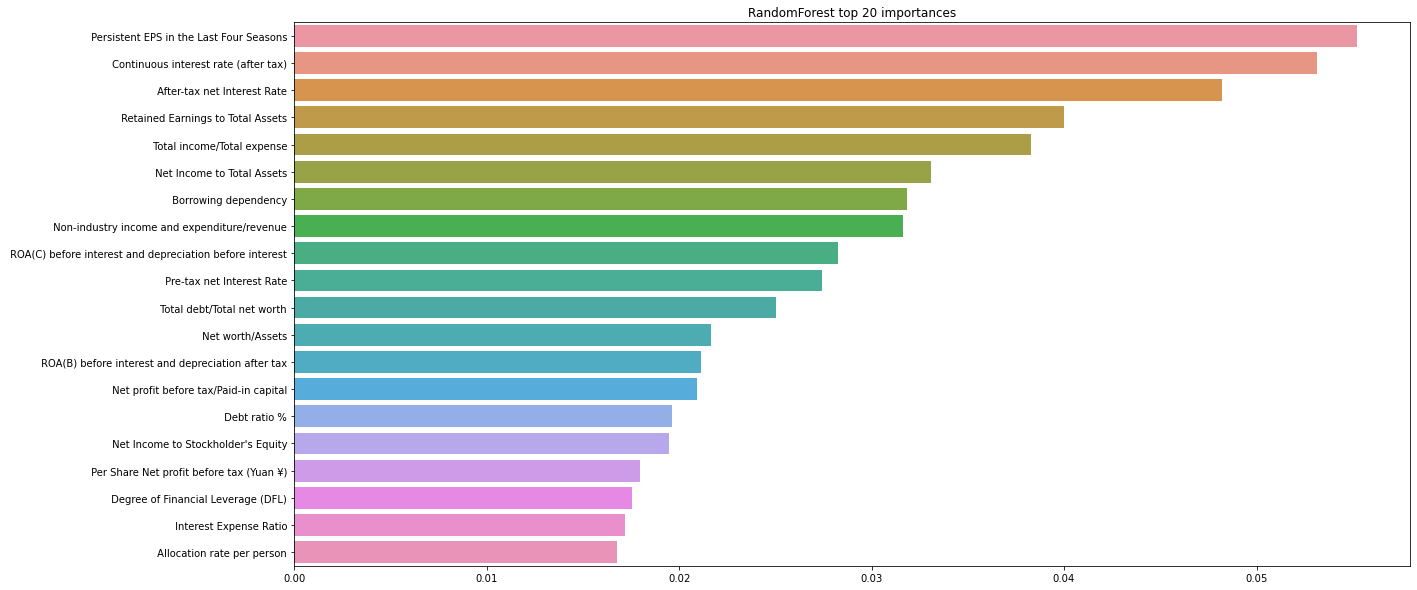

In [75]:
imp_valuesrf = pd.Series(rfconc_final.feature_importances_, index = Xconc.columns)
imp_valuesrf.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (20,10))
sns.barplot( x = imp_valuesrf[:20], y = imp_valuesrf.index[:20])
plt.title("RandomForest top 20 importances")
plt.show()

### xgboost

In [77]:
import xgboost
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

In [78]:
t1=datetime.now()
param_grid = {
    'max_depth':[5,6,7,8,9,10], 
    'n_estimators':np.arange(101,401,40), # 20 steps
    'min_child_weight' : [0,0.1,0.5,0.8],
    'eta' : [0.1],
    'colsample_bytree':[0.7,0.9],
    'alpha' : [1,1.5,2],
    'reg_alpha' : [1,1.5,2]
}

gridxgconc = RandomizedSearchCV(XGBClassifier(objective = 'binary:logistic',
                                       eval_metric = 'error'), param_distributions=param_grid, cv=3, n_iter = 50,
                      verbose=1, scoring='f1', refit=True
                      )
gridxgconc_result = gridxgconc.fit(Xconc, yconc)
t2=datetime.now()

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [79]:
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Total computing time = 671.819638 seconds


In [87]:
xgconc_df = pd.DataFrame(gridxgconc_result.cv_results_)

xgconc_final = gridxgconc_result.best_estimator_

xgconc_y_pred = xgconc_final.predict(X_test)
xgconc_f1 = f1_score(y_test, xgconc_y_pred)
res['XG Boost'] = xgconc_f1
print("F1 score with xgboost : {:.6f}".format(xgconc_f1))

F1 score with xgboost : 0.649351


In [88]:
xgconc_final

XGBClassifier(alpha=1.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eta=0.1, eval_metric='error', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=5,
              min_child_weight=0.1, missing=nan, monotone_constraints='()',
              n_estimators=341, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1, ...)

In [89]:
print('***Result of XGboost***')
print(classification_report(y_test, xgconc_y_pred))

***Result of XGboost***
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1170
           1       0.62      0.68      0.65        37

    accuracy                           0.98      1207
   macro avg       0.81      0.83      0.82      1207
weighted avg       0.98      0.98      0.98      1207



## Data Visualization with the Best Result

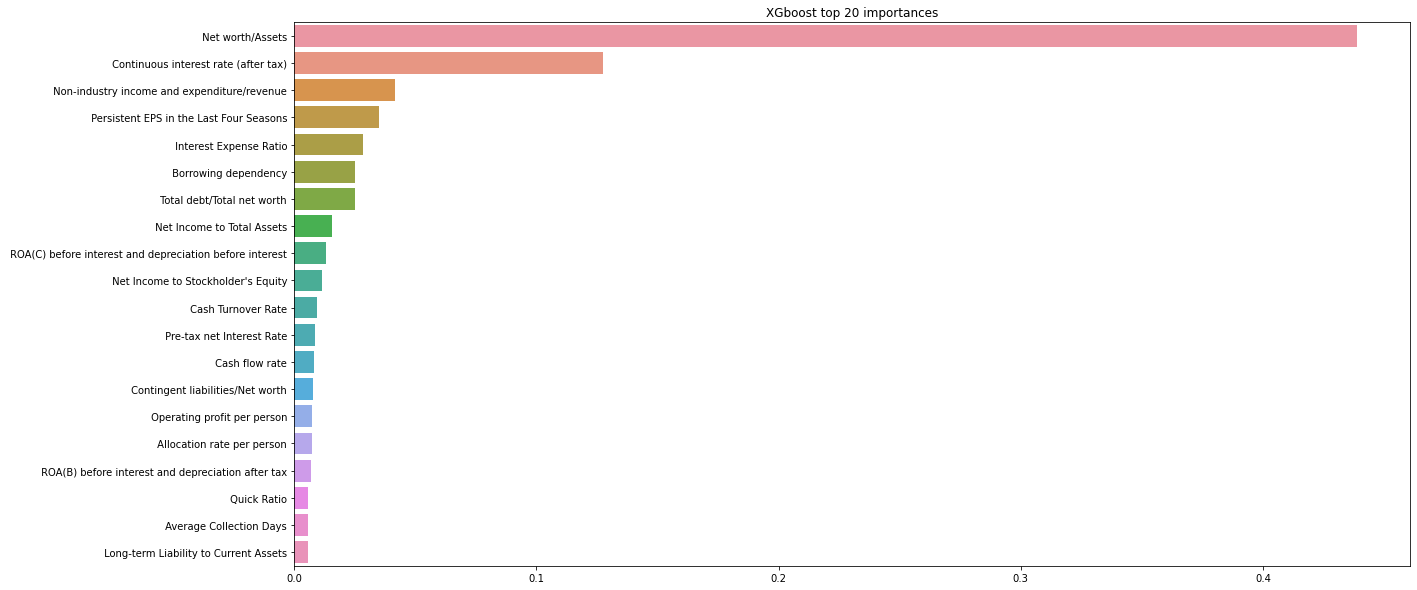

In [90]:
imp_values = pd.Series(xgconc_final.feature_importances_, index = Xconc.columns)
imp_values.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (20,10))
sns.barplot( x = imp_values[:20], y = imp_values.index[:20])
plt.title("XGboost top 20 importances")
plt.show()

# Feature Engineering

### Principal Component Analysis

In [92]:
from sklearn.decomposition import PCA
variance_ratio = 0.8
pca = PCA(n_components = variance_ratio)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Number of PCs {}".format(X_pca.shape[-1]))
print("Reduced {} features while explaining {}% of total variance".format((X_scaled.shape[-1] - X_pca.shape[-1]),
                                                                         variance_ratio*100))

Number of PCs 30
Reduced 63 features while explaining 80.0% of total variance


In [93]:
X_trpc, X_testpc, y_trpc, y_testpc = train_test_split(X_pca,y,
                                                test_size = 0.2, random_state=42)
OverXpc, Overypc = oversampleS.fit_resample(X_trpc, y_trpc) #train set only

### PCA with XG Boost

In [94]:
t1=datetime.now()
param_pca = {
    'max_depth':[4,5,6,7,8,9],
    'n_estimators':np.arange(101,401,50),
    'min_child_weight' : [0.1,0.5,0.8],
    'eta' : [0.1],
    'colsample_bytree':[0.7,0.9],
    'alpha' : [1,2]
}
pcaxgconc = RandomizedSearchCV(XGBClassifier(objective = 'binary:logistic',
                                       eval_metric = 'error'), param_distributions=param_pca, cv=3, n_iter = 40,
                      verbose=1, scoring='f1', refit=True
                      )
pcaxgconc_result = pcaxgconc.fit(OverXpc, Overypc)#, eval_set = [(X_val,y_val)])
t2=datetime.now()

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [95]:
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Total computing time = 254.993395 seconds


In [98]:
pcaxgconc_df = pd.DataFrame(pcaxgconc_result.cv_results_)

pcaxgconc_final = pcaxgconc_result.best_estimator_

pcaxgconc_y_pred = pcaxgconc_final.predict(X_testpc)
pcaxgconc_f1 = f1_score(y_testpc, pcaxgconc_y_pred)

res['PCA_XG Boost'] = pcaxgconc_f1
print("F1 score with pca xgboost : {:.6f}".format(pcaxgconc_f1))

F1 score with pca xgboost : 0.426966


In [99]:
print('***Result of XGboost with PCA***')
print(classification_report(y_testpc, pcaxgconc_y_pred))

***Result of XGboost with PCA***
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1170
           1       0.37      0.51      0.43        37

    accuracy                           0.96      1207
   macro avg       0.67      0.74      0.70      1207
weighted avg       0.97      0.96      0.96      1207



### Feature Selection

In [100]:
from sklearn.feature_selection import RFECV
t1 = datetime.now()
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1) #random forest => xgboost takes too long
rfecv = RFECV(model, step=5, scoring='f1', min_features_to_select = 10, cv=3, verbose=1)
rfecvfit = rfecv.fit(Xconc,yconc)
t2 = datetime.now()

Fitting estimator with 93 features.
Fitting estimator with 88 features.
Fitting estimator with 83 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 48 features.
Fitting estimator with 43 features.
Fitting estimator with 38 features.
Fitting estimator with 33 features.
Fitting estimator with 28 features.
Fitting estimator with 23 features.
Fitting estimator with 18 features.
Fitting estimator with 13 features.
Fitting estimator with 93 features.
Fitting estimator with 88 features.
Fitting estimator with 83 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 48 features.
Fitting estimator with 43 fe

In [101]:
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Total computing time = 161.302988 seconds


In [102]:
print("*********************")
print("Remaining Features {}".format(rfecv.get_support().sum()))
print("Reduced {} Features".format(Xconc.shape[-1] - rfecv.get_support().sum()))

*********************
Remaining Features 83
Reduced 10 Features


In [103]:
keep = Xconc.columns[rfecv.get_support()]
X_selected_tr = Xconc[keep] 
X_selected_test = X_test[keep]
print("Deleted Columns : \n", Xconc.columns[~rfecv.get_support()])

Deleted Columns : 
 Index([' Operating Expense Rate', ' Tax rate (A)',
       ' Inventory and accounts receivable/Net value',
       ' Fixed Assets Turnover Frequency', ' Current Assets/Total Assets',
       ' Current Asset Turnover Rate', ' Working capitcal Turnover Rate',
       ' Fixed Assets to Assets', ' Cash Flow to Liability',
       ' Cash Flow to Equity'],
      dtype='object')


In [104]:
imp_values[Xconc.columns[~rfecv.get_support()]] 
# importance at the best model => Result acceptable as very low values are shown

 Operating Expense Rate                         0.001034
 Tax rate (A)                                   0.000793
 Inventory and accounts receivable/Net value    0.002838
 Fixed Assets Turnover Frequency                0.001795
 Current Assets/Total Assets                    0.001467
 Current Asset Turnover Rate                    0.002124
 Working capitcal Turnover Rate                 0.001432
 Fixed Assets to Assets                         0.001191
 Cash Flow to Liability                         0.001250
 Cash Flow to Equity                            0.001319
dtype: float32

#### Random Forest

In [105]:
rfparam_grid = {
    'n_estimators':[100,150, 200, 250, 300],
    "max_depth": [None],
    'bootstrap': [True, False],
    'min_samples_split' : [6,8,10]
}

In [106]:
selected_rf = RandomizedSearchCV(RandomForestClassifier(random_state = 1),
                                param_distributions=rfparam_grid, cv=5,
                      verbose=1, scoring='f1', refit=True
                      )
selected_rf_result = selected_rf.fit(X_selected_tr, yconc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [109]:
selected_rf_df = pd.DataFrame(selected_rf_result.cv_results_)

selected_rf_final = selected_rf_result.best_estimator_

selected_rf_y_pred = selected_rf_final.predict(X_selected_test)
selected_rf_f1 = f1_score(y_test, selected_rf_y_pred)

res['Feature Selection_RF'] = selected_rf_f1
print("F1 score with rf with Feature Selection : {:.6f}".format(selected_rf_f1))

F1 score with rf with Feature Selection : 0.560000


In [110]:
print('***Result of RandomForest with Feature Selection***')
print(classification_report(y_test, selected_rf_y_pred))

***Result of RandomForest with Feature Selection***
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1170
           1       0.55      0.57      0.56        37

    accuracy                           0.97      1207
   macro avg       0.77      0.78      0.77      1207
weighted avg       0.97      0.97      0.97      1207



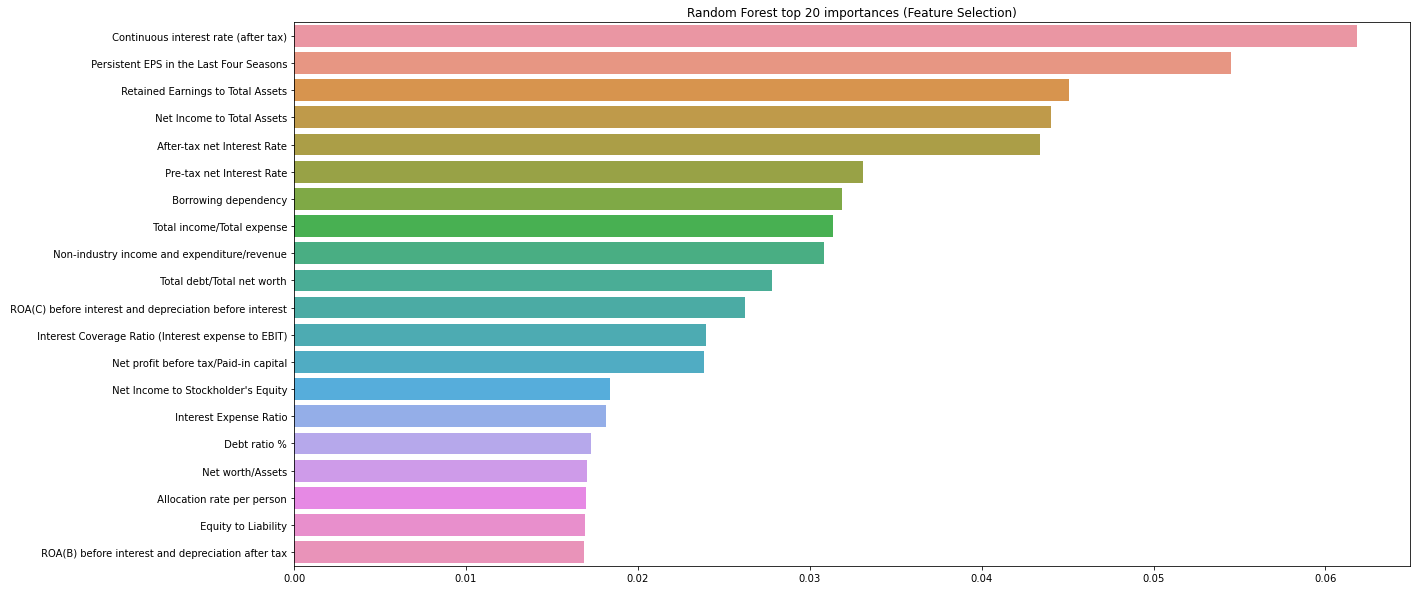

In [111]:
imp_values_srf = pd.Series(selected_rf_final.feature_importances_, index = X_selected_tr.columns)
imp_values_srf.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (20,10))
sns.barplot( x = imp_values_srf[:20], y = imp_values_srf.index[:20])
plt.title("Random Forest top 20 importances (Feature Selection)")
plt.show()

#### XGboost

In [113]:
t1=datetime.now()
param_grid = {
    'max_depth':[5,6,7,8],
    'n_estimators':np.arange(101,501,20),
    'min_child_weight' : [0,0.1,0.5,0.8],
    'eta' : [0.1],
    'colsample_bytree':[0.5,0.7,0.9],
    'alpha' : [1,1.5,2],
    'reg_alpha' : [1,1.5,2]
}
xg = RandomizedSearchCV(XGBClassifier(objective = 'binary:logistic',
                                       eval_metric = 'error'), param_distributions=param_grid, cv=3, n_iter = 25,
                      verbose=1, scoring='f1', refit=True
                      )
xg_result = xg.fit(X_selected_tr, yconc)#, eval_set = [(X_val,y_val)])
t2=datetime.now()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [114]:
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Total computing time = 287.349134 seconds


In [118]:
xg_df = pd.DataFrame(xg_result.cv_results_)

xg_final = xg_result.best_estimator_

xg_y_pred = xg_final.predict(X_selected_test)
xg_f1 = f1_score(y_test, xg_y_pred)

res['Feature Selection_XG Boost'] = xg_f1
print("F1 score with Feature Selection & xgboost : {:.6f}".format(xg_f1))

F1 score with Feature Selection & xgboost : 0.609756


In [119]:
print('***Result of XGboost with Feature Selection***')
print(classification_report(y_test, xg_y_pred))

***Result of XGboost with Feature Selection***
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1170
           1       0.56      0.68      0.61        37

    accuracy                           0.97      1207
   macro avg       0.77      0.83      0.80      1207
weighted avg       0.98      0.97      0.97      1207



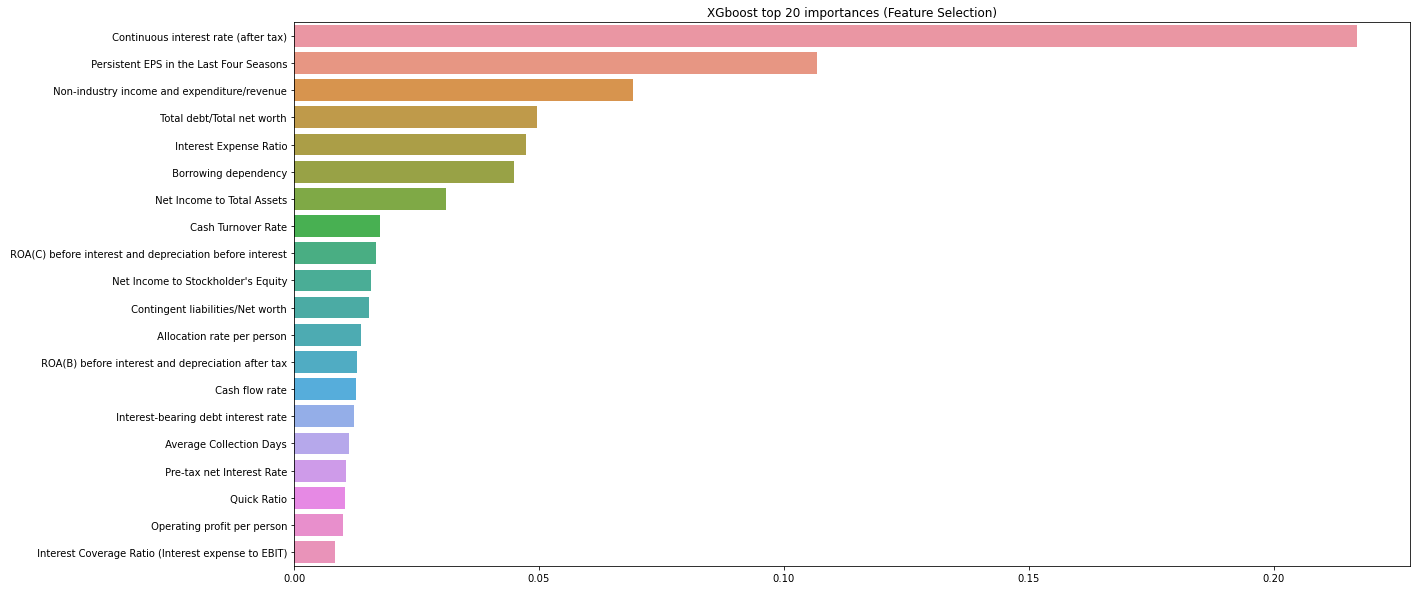

In [120]:
imp_values_sxg = pd.Series(xg_final.feature_importances_, index = X_selected_tr.columns)
imp_values_sxg.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (20,10))
sns.barplot( x = imp_values_sxg[:20], y = imp_values_sxg.index[:20])
plt.title("XGboost top 20 importances (Feature Selection)")
plt.show()

## Kmeans Clustering

Text(0.5, 1.0, 'Elbow curve')

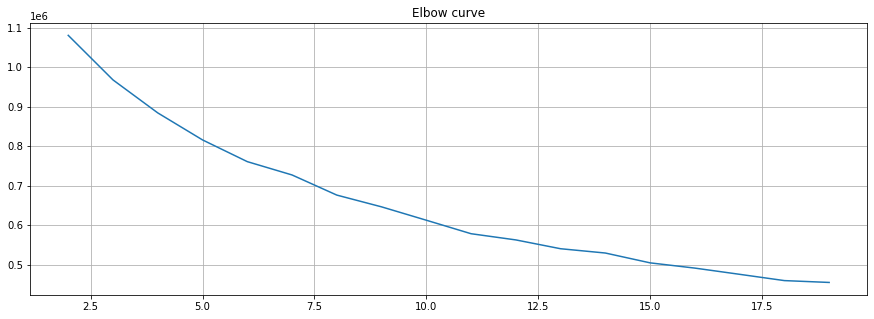

In [123]:
from sklearn.cluster import KMeans
X=Xconc.copy()
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
# No good point to cluster

## Result

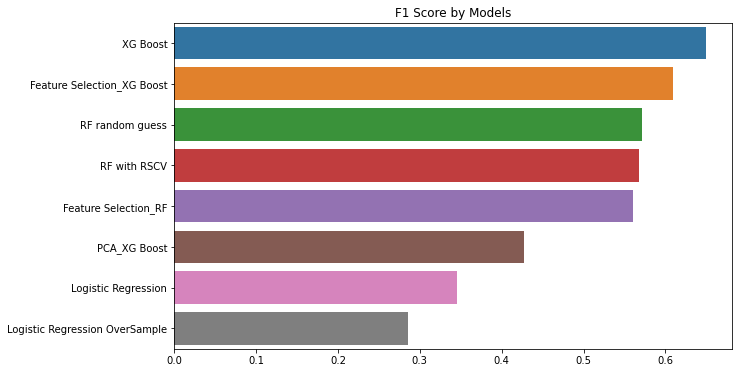

In [124]:
res_sr = pd.Series(res)
res_sr.sort_values(ascending = False, inplace = True)
plt.figure(figsize = (10,6))
sns.barplot( x = res_sr, y = res_sr.index)
plt.title("F1 Score by Models")
plt.show()